<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 5px; height: 75px">

# The Caterpillar Effect : A Caterpillar Recognition Model
Author: Sharifah Nurulhuda, DSI-SG-41 

### 02a_Preprocessing and Modelling (CNN)

**Introduction**

In this notebook, we are training a multi-class CNN from scratch.

Here is a typical CNN framework:

<img src="https://editor.analyticsvidhya.com/uploads/25366Convolutional_Neural_Network_to_identify_the_image_of_a_bird.png" style="float: center; height: 250px">

We feed our training images through this neural network, which will learn to identify features and patterns throughout the images and attempt to classify them accurately.

However, there are drawbacks to creating CNNs from scratch. 

The following is taken from __[Disadvantages of CNN models.](https://sandeep-bhuiya01.medium.com/disadvantages-of-cnn-models-95395fe9ae40)__

* Heavy Computational Power needed (depending on the number of convolution and pooling layers)
* Poor Classification Performance when presented with a smaller dataset without data augmentation.

We will also look at the effect of `Early Stopping` regularisation on the accuracy and other metrics of our model.



#### 2.1 Import Libraries

In [1]:
# libraries for importing and exporting images
import os
import cv2
import imghdr

#libraries for data processing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#libraries for modelling
import tensorflow as tf
os.environ["TF_USE_LEGACY_KERAS"]='True'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras import callbacks


#libraries for evaluating the model
from sklearn.metrics import classification_report

#libraries for saving model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

#libraries for loading model
from tensorflow.keras.preprocessing import image # to do image processing in the required format for predictions
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings("ignore")

/Users/hudalhabsyi/github_local-personal_repo/ga_portfolio_local/project-capstone-the-caterpillar-effect/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### 2.2 Checking image formats

In the next blocks of code, we check to see if the images in our augmented dataset are of the correct file format. We go through each image to check if the image's extension matches the ones defined in the list of accepted extensions.

In [2]:
#define the directory for 
data_dir= '../data/augmented'

#define accepted image extensions
image_exts = ['jpeg','jpg','bmp','png']

The following code block searches through the `data_dir` to ensure that all images extensions are found in the `image_exts` list.

In [3]:
#checking that each image in the directory has the correct extension
for image_class in os.listdir(data_dir):
    if not image_class.startswith('.'):         #to ignore hidden files with '.' as first char in extension (e.g. '.DS_Store')
        for imge in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class,imge)
            try:
                img = cv2.imread(image_path)        #check if it is a valid image
                tip = imghdr.what(image_path)
                if tip not in image_exts:           #check if it is a valid image extension
                    print('Image not in ext list{}'.format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print('Issue with image {}'.format(image_path))
    print('All images in correct extension.')


All images in correct extension.
All images in correct extension.
All images in correct extension.
All images in correct extension.


#### 2.3 Checking Labels

In this section, we check that the images and mapped accordingly to the correct labels. These labels are found and mapped to each picture according to the folder they were found in.

In [4]:
class_images = image.ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(data_dir, 
                                                                                target_size=(224,224), 
                                                                                class_mode='categorical'
                                                                                )

Found 800 images belonging to 4 classes.


In [5]:
class_images

In [6]:
# Check the classes that ImageDataGenerator was able to find using .class_indices
class_labels = class_images.class_indices # save output mappings dictionary to 'labels' variable to use later for predictions
print(class_labels) 

{'chocolate_pansy': 0, 'lime_caterpillar': 1, 'painted_jezebel': 2, 'plain_tiger': 3}


#### 2.4 Splitting Data

We need to split the data into three parts:
* Training Data (data for training the model)
* Testing Data (data seen by model post-training to test the model's accuracy)
* Validation Data (validate the model as it is being trained)

We set aside some data for validation to check and prevent the model from overfitting. 

We can do this later in the modelling stage.

**Checking label allocation**

First, we need to transform our images into a numpy array and extract the corresponding labels.

At this stage, we resize the images to `(256,256)` for consistency for modelling.

In [7]:
# Path to the folder containing your images
folder_path = data_dir

# List all subdirectories in the folder
subdirectories = [subdir for subdir in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subdir))]

# Initialize lists to store images and labels
images = []
labels = []

# Define target dimensions for resizing
target_width = 256
target_height = 256

# Loop over each subdirectory
for i, subdir in enumerate(subdirectories):
    # List all files in the subdirectory
    file_names = os.listdir(os.path.join(folder_path, subdir))
    
    # Load images from the subdirectory
    for file_name in file_names:
        file_path = os.path.join(folder_path, subdir, file_name)
        imgs = cv2.imread(file_path)
        # Resize the image to the target dimensions
        imgs = cv2.resize(imgs, (target_width, target_height))
        images.append(imgs)
        labels.append(i)  # Use the index of the subdirectory as the label

# Convert images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)


**Checking that both NumPy arrays are of the same length**

We should confirm that the arrays are both equal in length, since they both contain all of our data (i.e. there should be the same number of images and labels).

In [8]:
len(images)

800

In [9]:
len(labels)

800

**Train Test Split**

We now use `train test split`. After splitting, `X_train` and `X_test` contain the images, `y_train` and `y_test` contain the corresponding labels.

We also need to ensure that our classes are balanced after splitting, so we should add `stratify = labels` when doing `train_test_split`.

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [11]:
print('Checking that both train and test have the right shape:')
print(f'X_train.shape : {X_train.shape}')
print(f'X_test.shape : {X_test.shape}')

print('\nChecking that all classes are balanced:')
print(f'Train, Class 0 : {np.count_nonzero(y_train == 0)}')
print(f'Train, Class 1 : {np.count_nonzero(y_train == 1)}')
print(f'Train, Class 2 : {np.count_nonzero(y_train == 2)}')
print(f'Train, Class 3 : {np.count_nonzero(y_train == 3)}')
print(f'Test, Class 0 : {np.count_nonzero(y_test == 0)}')
print(f'Test, Class 1 : {np.count_nonzero(y_test == 1)}')
print(f'Test, Class 2 : {np.count_nonzero(y_test == 2)}')
print(f'Test, Class 3 : {np.count_nonzero(y_test == 3)}')



Checking that both train and test have the right shape:
X_train.shape : (640, 256, 256, 3)
X_test.shape : (160, 256, 256, 3)

Checking that all classes are balanced:
Train, Class 0 : 160
Train, Class 1 : 160
Train, Class 2 : 160
Train, Class 3 : 160
Test, Class 0 : 40
Test, Class 1 : 40
Test, Class 2 : 40
Test, Class 3 : 40


We have now confirmed the following:

* true labels for the dataset
* classes are balanced.

We can now move on to modelling.

#### 2.5 Preprocessing Data (Scaling)

First, we need to scale our data to normalise the images between 0 and 1. 

Scaling also improves the model performance and allow the model to run faster in a more stable manner.

We can manually do this by dividing each of the X data by 255 (pixel values range from 0-255).

In [12]:
#Scaling X_train to between 0 and 1
X_train_scaled = X_train / 255
print(f'Minimum: {X_train_scaled[0].min()}')
print(f'Maximum: {X_train_scaled[0].max()}')


Minimum: 0.011764705882352941
Maximum: 1.0


In [13]:
#Scaling X_test to between 0 and 1
X_test_scaled = X_test / 255
print(f'Minimum: {X_test_scaled[0].min()}')
print(f'Maximum: {X_test_scaled[0].max()}')


Minimum: 0.0
Maximum: 1.0


From here, we can see that our values of X are between 0 and 1, so we can proceed with modelling.

#### 2.6 CNN Model without Regularisation

##### 2.6.1 Defining Model

We start by instantiating the model using `Sequential()`.

Next we add a `Conv2D` layer, pairing it up with a `MaxPooling2D` layer each time.

We do this, changing the hyperparameters as we go along, and using the `ReLU` activation function. This keeps all values positive. `input_shape` is also kept at the same values throughout for consistency.

Next we `Flatten()` into a one-dimensional vector. This will allow us to connect the convolution layers to the upcoming fully connected layers.

`Dense` layers are used to fully connect the different filters together with the calculated weights. This layer uses the same `ReLU` activation layer for all except the final one. Since this is a multiclass NN, we use `softmax` activation in the final layer in order to have a multiclass output.

In [14]:
#Instantiate the model

model = Sequential()

#defining the layers of the model

model.add(Conv2D(filters = 16, 
                 kernel_size = (3,3), 
                 padding = 'same',
                 activation ='relu', 
                 input_shape = (256,256,3)))

model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 32, 
                 kernel_size = (3,3), 
                 padding = 'same',
                 activation ='relu', 
                 input_shape = (256,256,3)))

model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(16, (3,3), 1, activation ='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation ='relu'))
model.add(Dense(4, activation = 'softmax'))         # we use softmax for multiclass classification

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15376)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,936,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,947,252 (15.06 MB)

 Trainable params: 3,947,252 (15.06 MB)

 Non-trainable params: 0 (0.00 B)

We define the `Adam` optimiser to have a `learning_rate` of 0.001, and use the loss function `Sparse Categorical CrossEntropy`.

In [15]:
# optimiser = Adam(learning_rate = 0.001)

model.compile(optimizer = 'Adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

##### 2.6.2 Training the Model

We first train the model without regularisation.

During train test split, we did not have validation as this can be done in the following function. We set epoch to 20 to allow for space for the code to run efficiently. Furthermore, with trial and error, this has been found to be the most ideal (provided no regularisation is used).

In [16]:
#fit the model with basic hyperparameters, including the validation_split
history = model.fit(X_train_scaled,
                    y_train,
                    epochs = 20,
                    validation_split = 0.2)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.3769 - loss: 1.5063 - val_accuracy: 0.5156 - val_loss: 1.0824
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.6044 - loss: 0.9800 - val_accuracy: 0.7188 - val_loss: 0.7387
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.7797 - loss: 0.6541 - val_accuracy: 0.7812 - val_loss: 0.5347
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.8644 - loss: 0.3892 - val_accuracy: 0.8906 - val_loss: 0.3161
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9336 - loss: 0.2400 - val_accuracy: 0.8438 - val_loss: 0.3910
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9178 - loss: 0.2398 - val_accuracy: 0.9297 - val_loss: 0.2089
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9886 - loss: 0.0875 - val_accuracy: 0.9531 - val_loss: 0.1733
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.9927 - loss: 0.0445 - val_accuracy: 0.

**Plot a line graph for `loss` VS `val_loss`**

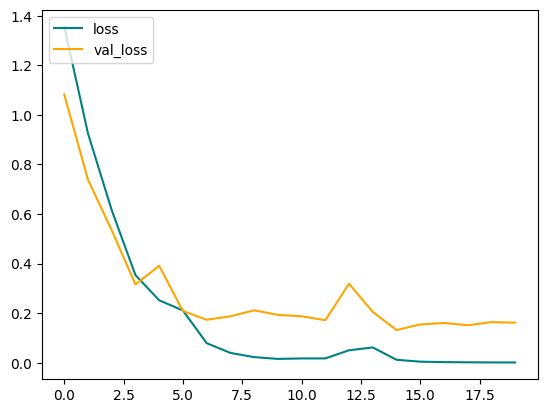

In [17]:
#loss

fig = plt.figure()

plt.plot(history.history['loss'], color = 'teal', label = 'loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'val_loss')

plt.legend(loc = 'upper left')
plt.show()

**Plot a line graph for `accuracy` VS `val_accuracy`**

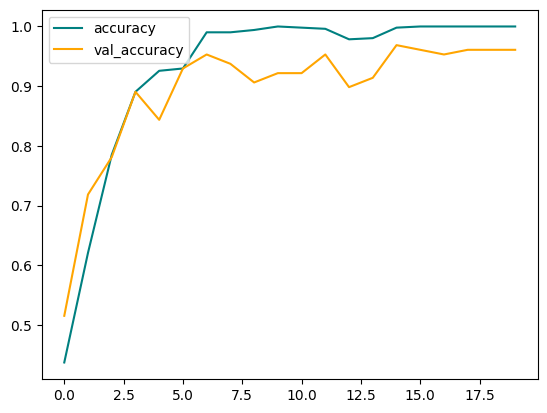

In [18]:
#accuracy

fig = plt.figure()

plt.plot(history.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color = 'orange', label = 'val_accuracy')

plt.legend(loc = 'upper left')
plt.show()

**Insights:**

The scores and visuals above are indicative of an overfitted model.

* Accuracy scores at 100%.

* Training Loss has a good decreasing trend up to epoch 2, before it started to increase.

* Validation loss scores are experiencing an increasing gap as the number of epochs progress. This is a good indication that we might need to use regularisation techniques to address overfitting.

##### 2.6.3 Testing the Model

**Generating Predicted Classes**

We need to convert our true X train and X test labels into a numpy array in order to input them into the classification report metric.

Next we generate the predicted labels and generate them into a numpy array.

In [19]:
# Define function: generate predicted classes as a numpy array

def pred_class(pred_prob_varname):

    pred_class_all = np.array([])
    for pred_prob_array in pred_prob_varname:
        pred_class = np.argmax(pred_prob_array)
        pred_class_all = np.append(pred_class_all, pred_class)
    
    return pred_class_all

In [20]:
# Obtain predicted probabilities and classes
train_pred  = model.predict(X_train_scaled)
train_pred_class = pred_class(train_pred)

test_pred = model.predict(X_test_scaled)
test_pred_class = pred_class(test_pred)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [21]:
y_test

array([2, 1, 1, 3, 2, 1, 2, 0, 0, 3, 0, 1, 2, 0, 0, 1, 0, 2, 0, 3, 2, 2,
       0, 2, 0, 3, 0, 1, 2, 0, 1, 2, 2, 0, 2, 0, 1, 3, 3, 3, 3, 3, 0, 0,
       2, 0, 2, 2, 0, 3, 0, 1, 3, 1, 2, 2, 1, 1, 3, 2, 1, 1, 0, 2, 1, 1,
       3, 0, 1, 3, 0, 3, 2, 2, 1, 0, 2, 1, 1, 0, 3, 3, 0, 1, 1, 3, 0, 3,
       3, 2, 0, 0, 2, 3, 0, 3, 2, 1, 0, 3, 3, 2, 0, 3, 2, 1, 3, 2, 0, 0,
       3, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 3, 2, 0, 1, 1, 0, 1, 1, 3, 0,
       3, 1, 1, 0, 3, 1, 3, 3, 2, 3, 1, 3, 1, 0, 3, 1, 2, 3, 0, 1, 3, 2,
       2, 3, 0, 3, 0, 1])

In [22]:
test_pred_class

array([2., 1., 1., 3., 2., 1., 0., 0., 0., 3., 0., 1., 2., 0., 0., 1., 0.,
       2., 0., 3., 2., 2., 0., 2., 0., 3., 0., 1., 2., 0., 1., 2., 2., 0.,
       2., 0., 1., 3., 3., 3., 3., 3., 0., 0., 2., 0., 2., 2., 0., 3., 0.,
       1., 3., 1., 2., 2., 1., 1., 3., 2., 1., 2., 0., 1., 1., 1., 3., 0.,
       1., 3., 0., 3., 2., 2., 1., 0., 2., 1., 1., 0., 3., 3., 0., 1., 1.,
       3., 0., 3., 3., 2., 0., 0., 1., 3., 0., 3., 2., 1., 0., 3., 3., 2.,
       0., 3., 2., 1., 3., 2., 0., 0., 3., 1., 2., 1., 2., 3., 0., 2., 2.,
       2., 2., 1., 3., 2., 0., 1., 1., 0., 1., 2., 3., 0., 3., 1., 1., 0.,
       3., 1., 3., 3., 0., 2., 1., 3., 1., 0., 3., 1., 2., 3., 0., 1., 3.,
       2., 2., 2., 0., 3., 0., 1.])

##### 2.6.4 Evaluating the Model

**Classification Report**

What they mean:

|Precision|Recall|F1-Score|Support|
|----|----|----|----|
|TP / (TP + FP)| TP / (TP + FP) |Harmonic Mean of Precision and Recall|Number of images in each class|


* High precision score: Whenever it predicts a positive outcome, it is more likely to be correct.

* High recall score: The higher the recall score, the less likely that a false negative was detected.

* High f1-score: F1-score strikes a balance between precision and recall.

In [23]:
# Print model evaluation metrics: "training" data
print("== Classification Report: Training Data ==", "\n")
print(classification_report(y_train, train_pred_class, target_names = ['chocolate_pansy', 'lime_caterpillar', 'painted_jezebel', 'plain_tiger']))

== Classification Report: Training Data == 

                  precision    recall  f1-score   support

 chocolate_pansy       0.99      0.99      0.99       160
lime_caterpillar       1.00      0.99      1.00       160
 painted_jezebel       0.99      0.99      0.99       160
     plain_tiger       0.99      0.99      0.99       160

        accuracy                           0.99       640
       macro avg       0.99      0.99      0.99       640
    weighted avg       0.99      0.99      0.99       640



In [24]:
# Print model evaluation metrics: "test" data
print("== Classification Report: Testing Data ==", "\n")
print(classification_report(y_test, test_pred_class, target_names = ['chocolate_pansy', 'lime_caterpillar', 'painted_jezebel', 'plain_tiger']))

== Classification Report: Testing Data == 

                  precision    recall  f1-score   support

 chocolate_pansy       0.93      1.00      0.96        40
lime_caterpillar       0.95      0.93      0.94        40
 painted_jezebel       0.90      0.88      0.89        40
     plain_tiger       0.97      0.95      0.96        40

        accuracy                           0.94       160
       macro avg       0.94      0.94      0.94       160
    weighted avg       0.94      0.94      0.94       160



**Insights:**

Comparing the scores, while there seems to be a chance of overfitting in the testing metrics (close to 100%), comparing with the testing data is important.



In this case, it is more important for us to have a high precision score as this might have dire consequences for the use case of this project. If a caterpillar is wrongly identified, it might not survive as the user might end up learning the wrong information and therefore, possibly providing the wrong feed, leading to starvation and death.

There is a significant difference in the metrics for precision in the `chocolate_pansy` and `painted_jezebel` classes.

#### 2.7 CNN model with Early Stopping regularisation

##### 2.7.1 Defining Model

We start by instantiating `model_r` using `Sequential()`.

Next we add a `Conv2D` layer, pairing it up with a `MaxPooling2D` layer each time.

We do this, changing the hyperparameters as we go along, and using the `ReLU` activation function. This keeps all values positive. `input_shape` is also kept at the same values throughout for consistency.

Next we `Flatten()` into a one-dimensional vector. This will allow us to connect the convolution layers to the upcoming fully connected layers.

`Dense` layers are used to fully connect the different filters together with the calculated weights. This layer uses the same `ReLU` activation layer for all except the final one. Since this is a multiclass NN, we use `softmax` activation in the final layer in order to have a multiclass output.

In [25]:
#Instantiate the model

model_r = Sequential()

#defining the layers of the model

model_r.add(Conv2D(filters = 16, 
                 kernel_size = (3,3), 
                 padding = 'same',
                 activation ='relu', 
                 input_shape = (256,256,3)))

model_r.add(MaxPooling2D(pool_size = (2,2)))

model_r.add(Conv2D(filters = 32, 
                 kernel_size = (3,3), 
                 padding = 'same',
                 activation ='relu', 
                 input_shape = (256,256,3)))

model_r.add(MaxPooling2D(pool_size = (2,2)))

model_r.add(Conv2D(16, (3,3), 1, activation ='relu'))
model_r.add(MaxPooling2D())

model_r.add(Flatten())

model_r.add(Dense(256, activation ='relu'))
model_r.add(Dense(4, activation = 'softmax'))         # we use softmax for multiclass classification

model_r.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 62, 62, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15376)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,936,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,947,252 (15.06 MB)

 Trainable params: 3,947,252 (15.06 MB)

 Non-trainable params: 0 (0.00 B)

We define the `Adam` optimiser to have a `learning_rate` of 0.001, and use the loss function `Sparse Categorical CrossEntropy`.

In [26]:
# optimiser = Adam(learning_rate = 0.001)

model_r.compile(optimizer = 'Adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

In keeping with the purpose of comparing the performance of the two models, we keep all other hyperparameters and factors the same for a fair comparison.

##### 2.7.2 Training the Model

We next train the model with regularisation, to compare the performances.

Since we are using `Early Stopping` as regularisation, we define the `callback` here. We set `patience` to '1', and monitor `val_loss` similar to the previous model.

We then fit the `model_r` with the same hyperparameters as the original `model`.

In [27]:
# Defining the Early Stopping regularisation function
call = callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [28]:
# Fitting the model with regularisation
history_r = model_r.fit(X_train_scaled,
                    y_train,
                    callbacks = call,
                    epochs = 20,
                    validation_split = 0.2)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.3638 - loss: 1.4254 - val_accuracy: 0.6875 - val_loss: 0.8417
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.7414 - loss: 0.7495 - val_accuracy: 0.7656 - val_loss: 0.6061
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.8578 - loss: 0.3976 - val_accuracy: 0.8438 - val_loss: 0.3643
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9047 - loss: 0.2660 - val_accuracy: 0.8750 - val_loss: 0.3209
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9727 - loss: 0.1390 - val_accuracy: 0.8906 - val_loss: 0.2582
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.9794 - loss: 0.0749 - val_accuracy: 0.9062 - val_loss: 0.2828
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.9967 - loss: 0.0342 - val_accuracy: 0.9141 - val_loss: 0.2491
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9937 - loss: 0.0183 - val_accuracy: 0.

**Plot a line graph for `loss` and `val_loss`**

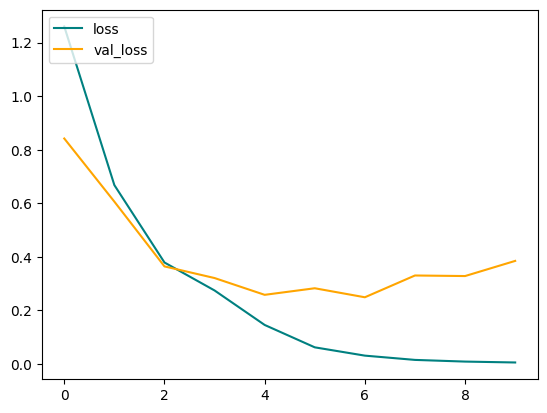

In [29]:
#loss

fig = plt.figure()

plt.plot(history_r.history['loss'], color = 'teal', label = 'loss')
plt.plot(history_r.history['val_loss'], color = 'orange', label = 'val_loss')

plt.legend(loc = 'upper left')
plt.show()

**Plot a line graph for `accuracy` and `val_accuracy`**

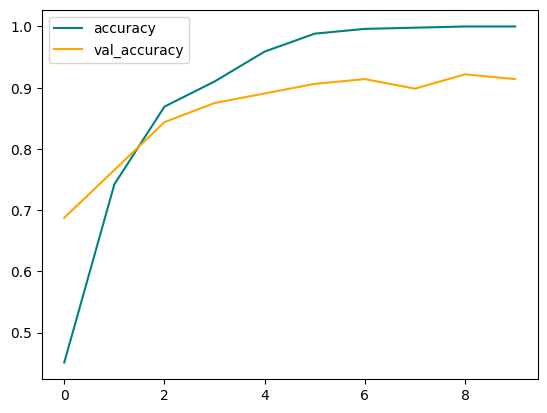

In [30]:
#accuracy

fig = plt.figure()

plt.plot(history_r.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(history_r.history['val_accuracy'], color = 'orange', label = 'val_accuracy')

plt.legend(loc = 'upper left')
plt.show()

**Insights:**

The scores and visuals above are indicative that early stopping had some effect on the performance of the model.

* Accuracy scores at 99.4%.

* Training Loss has a good decreasing trend up to epoch 4, before it started to increase.

* Validation loss scores are experiencing an increasing gap past epoch 4, though the gaps are smaller than that of the basic CNN model.

##### 2.7.3 Testing the Model

**Generating Predicted Classes**

We need to convert our true X train and X test labels into a numpy array in order to input them into the classification report metric.

First, we generate the predicted labels into a NumPy array.

In [31]:
# Obtain predicted probabilities and classes
train_pred_r  = model_r.predict(X_train_scaled)
train_pred_class_r = pred_class(train_pred_r)

test_pred_r = model_r.predict(X_test_scaled)
test_pred_class_r = pred_class(test_pred_r)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [32]:
y_test

array([2, 1, 1, 3, 2, 1, 2, 0, 0, 3, 0, 1, 2, 0, 0, 1, 0, 2, 0, 3, 2, 2,
       0, 2, 0, 3, 0, 1, 2, 0, 1, 2, 2, 0, 2, 0, 1, 3, 3, 3, 3, 3, 0, 0,
       2, 0, 2, 2, 0, 3, 0, 1, 3, 1, 2, 2, 1, 1, 3, 2, 1, 1, 0, 2, 1, 1,
       3, 0, 1, 3, 0, 3, 2, 2, 1, 0, 2, 1, 1, 0, 3, 3, 0, 1, 1, 3, 0, 3,
       3, 2, 0, 0, 2, 3, 0, 3, 2, 1, 0, 3, 3, 2, 0, 3, 2, 1, 3, 2, 0, 0,
       3, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 3, 2, 0, 1, 1, 0, 1, 1, 3, 0,
       3, 1, 1, 0, 3, 1, 3, 3, 2, 3, 1, 3, 1, 0, 3, 1, 2, 3, 0, 1, 3, 2,
       2, 3, 0, 3, 0, 1])

In [33]:
test_pred_class_r

array([2., 1., 1., 3., 2., 0., 0., 0., 0., 3., 0., 1., 2., 0., 0., 1., 0.,
       2., 0., 3., 2., 2., 0., 2., 0., 3., 0., 1., 2., 0., 1., 2., 2., 0.,
       2., 0., 1., 3., 3., 3., 3., 3., 0., 0., 2., 0., 2., 2., 0., 3., 0.,
       1., 3., 1., 2., 2., 1., 1., 3., 2., 1., 0., 0., 2., 1., 1., 3., 0.,
       1., 3., 0., 3., 2., 2., 1., 0., 2., 1., 1., 0., 3., 3., 0., 1., 1.,
       3., 0., 3., 3., 2., 0., 0., 2., 3., 0., 3., 2., 1., 0., 3., 3., 2.,
       0., 3., 2., 1., 3., 2., 0., 2., 3., 0., 2., 1., 2., 3., 0., 2., 2.,
       2., 2., 1., 3., 2., 0., 1., 1., 0., 1., 2., 3., 0., 3., 1., 1., 0.,
       3., 1., 3., 0., 2., 3., 1., 3., 1., 0., 3., 1., 2., 0., 0., 1., 3.,
       2., 2., 0., 0., 3., 0., 1.])

##### 2.7.4 Evaluating the Model

**Classification Reports**

What they mean:

|Precision|Recall|F1-Score|Support|
|----|----|----|----|
|TP / (TP + FP)| TP / (TP + FP) |Harmonic Mean of Precision and Recall|Number of images in each class|


* High precision score: Whenever it predicts a positive outcome, it is more likely to be correct.

* High recall score: The higher the recall score, the less likely that a false negative was detected.

* High f1-score: F1-score strikes a balance between precision and recall.

In [34]:
# Print model evaluation metrics: "training" data
print("== Classification Report: Training Data ==", "\n")
print(classification_report(y_train, train_pred_class_r, target_names = ['chocolate_pansy', 'lime_caterpillar', 'painted_jezebel', 'plain_tiger']))

== Classification Report: Training Data == 

                  precision    recall  f1-score   support

 chocolate_pansy       0.97      0.99      0.98       160
lime_caterpillar       1.00      0.97      0.99       160
 painted_jezebel       0.99      0.98      0.98       160
     plain_tiger       0.98      0.99      0.98       160

        accuracy                           0.98       640
       macro avg       0.98      0.98      0.98       640
    weighted avg       0.98      0.98      0.98       640



In [35]:
# Print model evaluation metrics: "test" data
print("== Classification Report: Testing Data ==", "\n")
print(classification_report(y_test, test_pred_class_r, target_names = ['chocolate_pansy', 'lime_caterpillar', 'painted_jezebel', 'plain_tiger']))

== Classification Report: Testing Data == 

                  precision    recall  f1-score   support

 chocolate_pansy       0.83      0.97      0.90        40
lime_caterpillar       1.00      0.88      0.93        40
 painted_jezebel       0.95      0.95      0.95        40
     plain_tiger       0.97      0.93      0.95        40

        accuracy                           0.93       160
       macro avg       0.94      0.93      0.93       160
    weighted avg       0.94      0.93      0.93       160



**Insights:**

Comparing the scores, while there seems to be a chance of overfitting in the testing metrics (close to 100%), comparing with the testing data is important.

The addition of early stopping does not seem to have made much difference in the scores. 

There is a need to explore other options to improve the metrics.

#### 2.8 Visualisation of Layers in CNN

In this section, we attempt to view the way in which the above model with early stopping "sees" the images and learns to recognise edges and colours in each image.

The codes from this section were adapted from __[Feature Map Visualization Using Tensorflow Keras.](https://www.tertiaryinfotech.com/feature-map-visualization-using-tensorflow-keras/)__

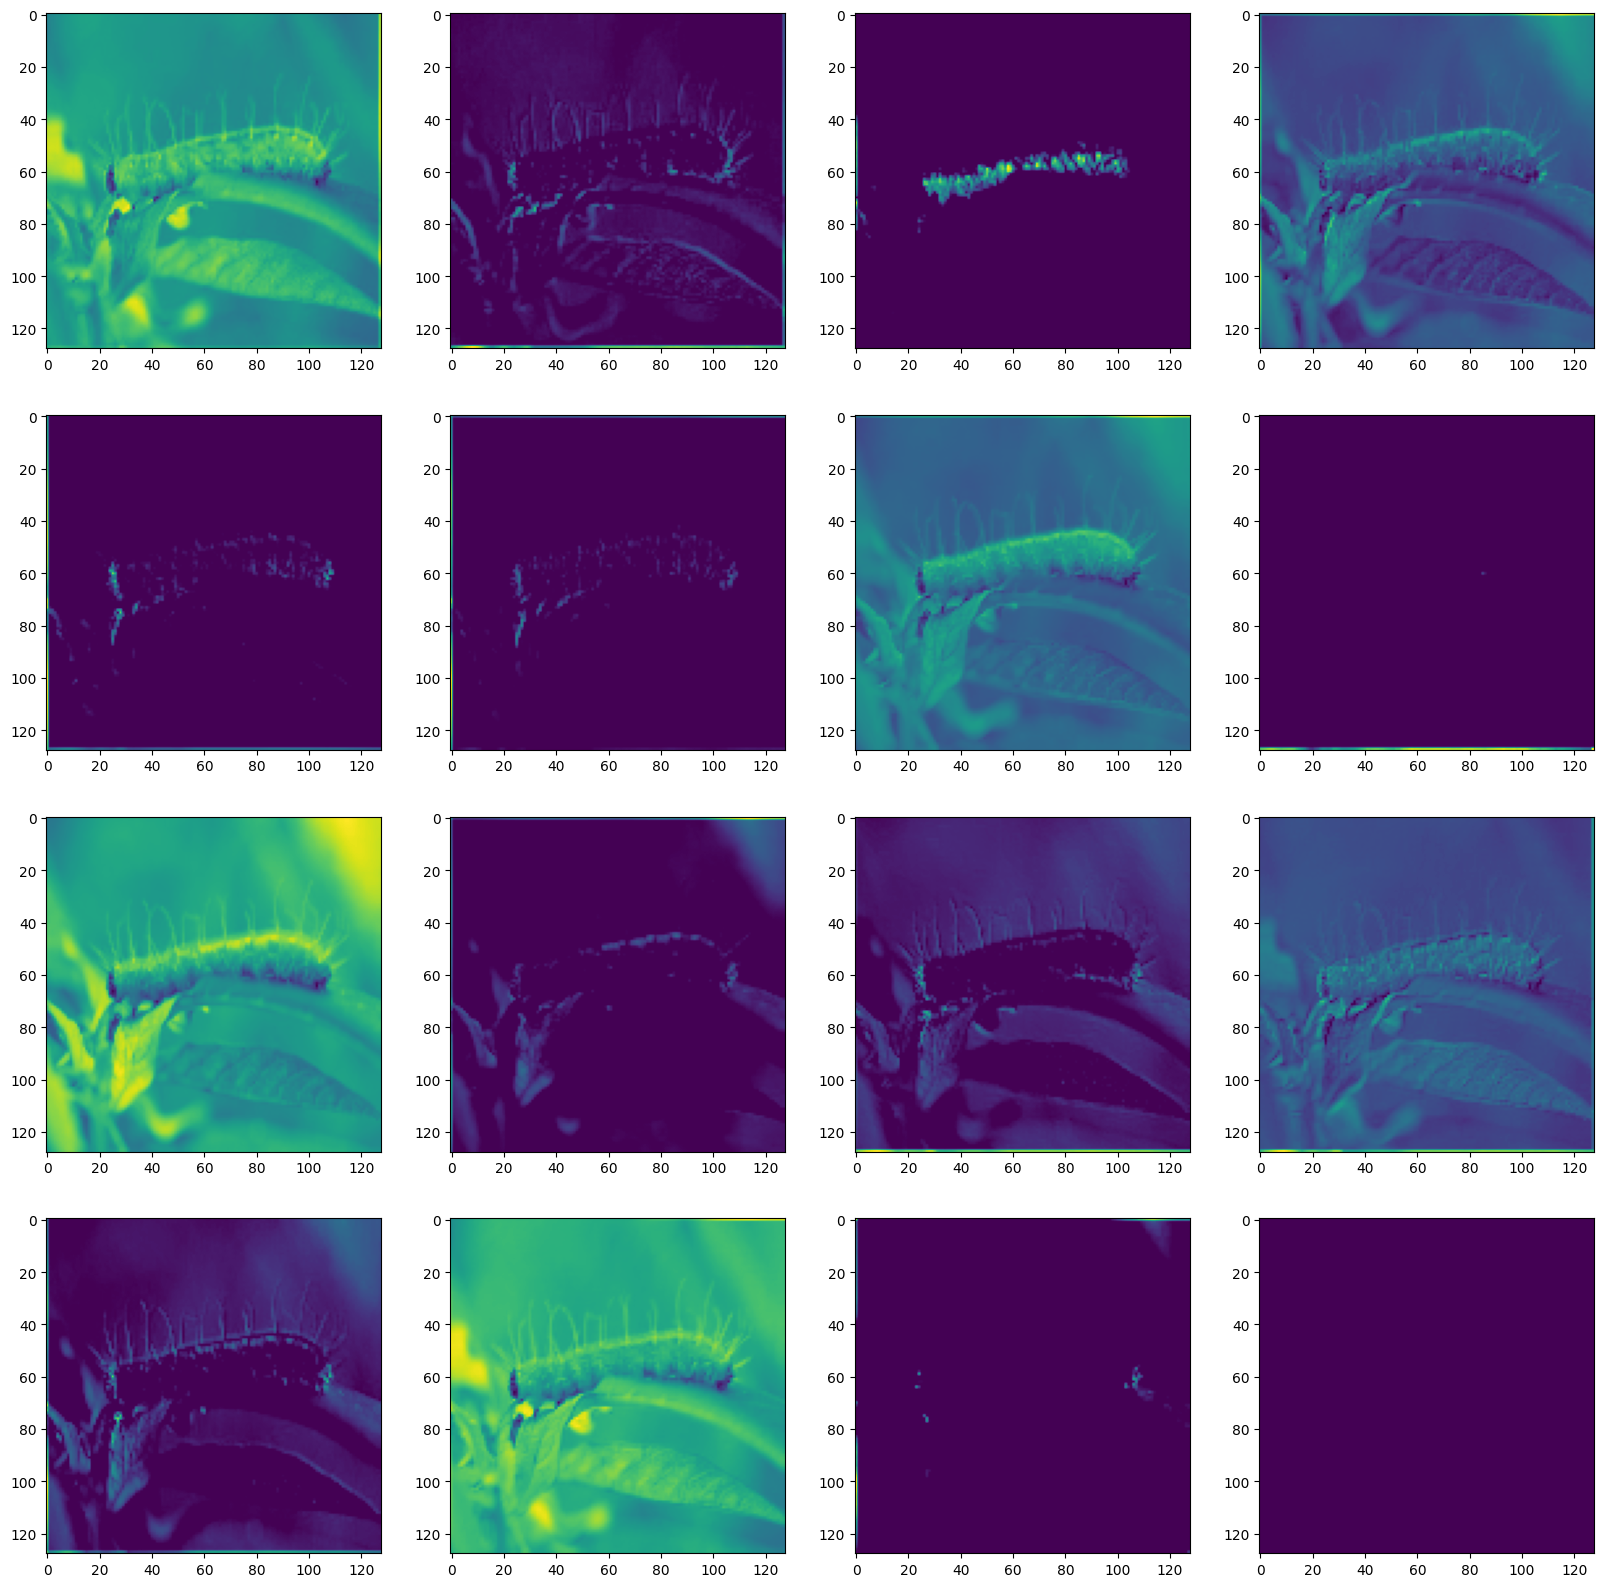

In [37]:
activation_model = Model(inputs=model_r.inputs, outputs=model_r.layers[1].output)

#define the directory for 
img = image.load_img('../data/test_for_prez/test9.jpg')

#resize image
img = img.resize((256,256))

#convert the image to a matrix of numbers
img = image.img_to_array(img)
img = np.expand_dims(img,axis=0)

#scaling image
img = img / 255

activation = activation_model(img)

plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(activation[0,:,:,i])
plt.show()

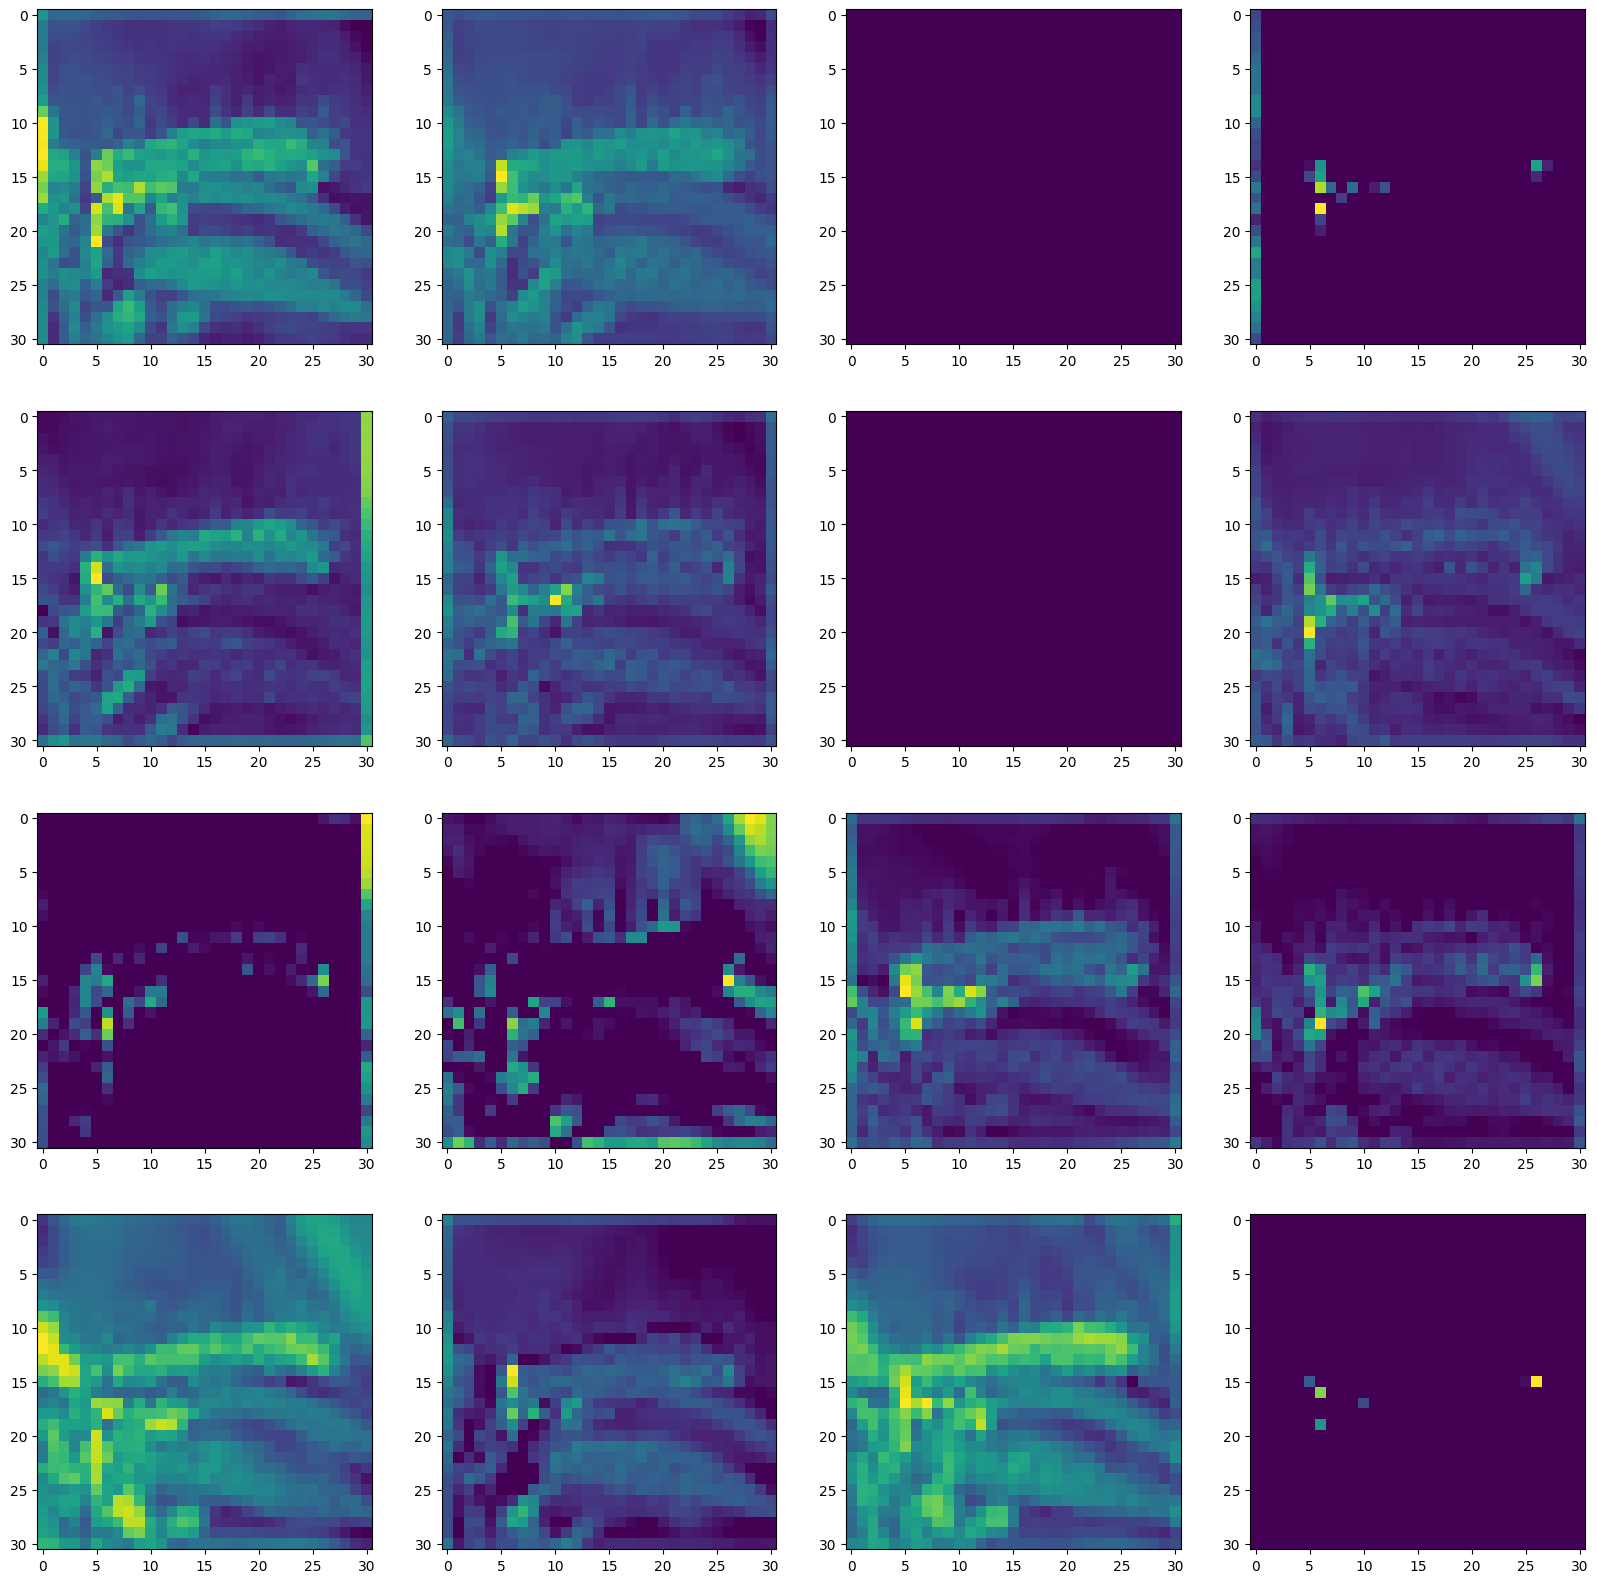

In [38]:
# base_model = VGG16(weights='imagenet')
activation_model = Model(inputs=model_r.inputs, outputs=model_r.layers[5].output)

#define the directory for 
img = image.load_img('../data/test_for_prez/test9.jpg')

#resize image
img = img.resize((256,256))

#convert the image to a matrix of numbers
img = image.img_to_array(img)
img = np.expand_dims(img,axis=0)

#scaling image
img = img / 255

activation = activation_model(img)

plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(activation[0,:,:,i])
plt.show()

#### 2.8 Export Model

Now that we've trained our models, we want to use the trained model to make predictions and deploy the model, so we first need to save the model.

In [40]:
model.save('../streamlit/the_caterpillar_effect_CNN.keras')

model.save('../streamlit/the_caterpillar_effect_CNN_r.keras')

#### 2.9 Some Concluding Thoughts

Creating a CNN from scratch is a challenging endeavour in itself. 

The results shown above seem to paint a generally positive picture of how well the model works, though there was some evidence of possible overfitting. While we tried to address that using Early Stopping, the model still struggles with unseen data not found in the test set when applied through the Streamlit app.

To improve on this, we might want to explore transfer learning using an established model like VGG-16 to see if the issue can be resolved.